In [1]:
# 在 EMA 之上，KD 超賣，低 RSI
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672543585000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 11:44:59  1193.39  1194.00  1194.00  1193.17    923.9797
1     2023-01-01 11:59:59  1194.00  1194.04  1194.39  1193.75    884.4465
2     2023-01-01 12:14:59  1194.05  1192.64  1194.05  1192.63   1580.2392
3     2023-01-01 12:29:59  1192.63  1192.18  1192.85  1190.57   3052.2194
4     2023-01-01 12:44:59  1192.18  1192.04  1192.93  1192.03    742.6090
...                   ...      ...      ...      ...      ...         ...
7439  2023-03-19 23:29:59  1792.92  1792.34  1797.98  1785.20   7865.8676
7440  2023-03-19 23:44:59  1792.33  1790.39  1797.11  1788.96   6700.8236
7441  2023-03-19 23:59:59  1790.39  1793.61  1805.00  1789.23   7319.4733
7442  2023-03-20 00:14:59  1793.61  1796.10  1800.95  1791.88   8304.4939
7443  2023-03-20 00:29:59  1796.09  1800.52  1806.00  1795.79  10534.2708

[7444 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
# sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
# ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,slowk,slowd
0,2023-01-01 11:44:59,1193.39,1194.00,1194.00,1193.17,923.9797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 11:59:59,1194.00,1194.04,1194.39,1193.75,884.4465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 12:14:59,1194.05,1192.64,1194.05,1192.63,1580.2392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 12:29:59,1192.63,1192.18,1192.85,1190.57,3052.2194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 12:44:59,1192.18,1192.04,1192.93,1192.03,742.6090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7439,2023-03-19 23:29:59,1792.92,1792.34,1797.98,1785.20,7865.8676,1779.532000,1792.200370,1779.532000,1766.863630,62.717622,1769.177924,48.181818,52.466802
7440,2023-03-19 23:44:59,1792.33,1790.39,1797.11,1788.96,6700.8236,1780.200000,1792.974231,1780.200000,1767.425769,59.949502,1769.388989,43.257576,47.045455
7441,2023-03-19 23:59:59,1790.39,1793.61,1805.00,1789.23,7319.4733,1780.733000,1794.339403,1780.733000,1767.126597,62.864203,1769.629994,51.388889,47.609428
7442,2023-03-20 00:14:59,1793.61,1796.10,1800.95,1791.88,8304.4939,1781.366000,1795.969672,1781.366000,1766.762328,64.986241,1769.893377,57.676768,50.774411


In [9]:
def conditions(df):

    # c1 Close > ema 200
    # c2 k < 15
    # c3 rsi < 50 & > 30

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'] >= df['ema']
        # c2
        df['c2'] = df['slowk'] <= 15
        # c3
        df['c3'] = (df['rsi'] < 50) & (df['rsi'] > 30)

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,slowk,slowd,c1,c2,c3,signal,openbuy
0,2023-01-01 11:44:59,1193.39,1194.00,1194.00,1193.17,923.9797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 11:59:59,1194.00,1194.04,1194.39,1193.75,884.4465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2023-01-01 12:14:59,1194.05,1192.64,1194.05,1192.63,1580.2392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
3,2023-01-01 12:29:59,1192.63,1192.18,1192.85,1190.57,3052.2194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-01-01 12:44:59,1192.18,1192.04,1192.93,1192.03,742.6090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7439,2023-03-19 23:29:59,1792.92,1792.34,1797.98,1785.20,7865.8676,1779.532000,1792.200370,1779.532000,1766.863630,62.717622,1769.177924,48.181818,52.466802,True,False,False,False,False
7440,2023-03-19 23:44:59,1792.33,1790.39,1797.11,1788.96,6700.8236,1780.200000,1792.974231,1780.200000,1767.425769,59.949502,1769.388989,43.257576,47.045455,True,False,False,False,False
7441,2023-03-19 23:59:59,1790.39,1793.61,1805.00,1789.23,7319.4733,1780.733000,1794.339403,1780.733000,1767.126597,62.864203,1769.629994,51.388889,47.609428,True,False,False,False,False
7442,2023-03-20 00:14:59,1793.61,1796.10,1800.95,1791.88,8304.4939,1781.366000,1795.969672,1781.366000,1766.762328,64.986241,1769.893377,57.676768,50.774411,True,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():
    
    tp_rsi = 68
    tp_slowk = 80
    tp_slowd = 80

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        ema_val = buydf['ema']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = ema_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = ema_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （RSI > 68 & KD > 80，或 紅Ｋ貫穿布林Ｍ，即刻出場）
    elif in_position == True and ((buydf.at[index, 'rsi'] >= tp_rsi) & (buydf.at[index, 'slowk'] >= tp_slowk) & (buydf.at[index, 'slowd'] >= tp_slowd)):
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low     Volume  \
212   2023-01-03 16:44:59  1215.19  1214.14  1215.20  1213.99  1289.5851   
213   2023-01-03 16:59:59  1214.15  1215.63  1216.27  1214.14  1787.3874   
242   2023-01-04 00:14:59  1211.77  1209.12  1212.76  1209.12  3078.3038   
351   2023-01-05 03:29:59  1256.57  1253.25  1261.46  1251.35  7611.1066   
352   2023-01-05 03:44:59  1253.25  1254.74  1255.86  1251.49  3332.1790   
...                   ...      ...      ...      ...      ...        ...   
7403  2023-03-19 14:29:59  1777.48  1772.20  1778.36  1770.25  4429.0171   
7404  2023-03-19 14:44:59  1772.20  1770.07  1774.21  1769.00  3031.2320   
7405  2023-03-19 14:59:59  1770.07  1769.46  1772.35  1767.20  4379.4918   
7406  2023-03-19 15:14:59  1769.46  1768.52  1770.22  1761.60  4810.5222   
7426  2023-03-19 20:14:59  1784.66  1793.14  1794.70  1783.85  8544.1782   

              sma         bb_u         bb_m         bb_l  ...      slowk  \
212   1215.

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2023-01-03 16:59:59  1214.15  1215.63  1216.27  1214.14  1215.509000   
1    2023-01-04 00:14:59  1211.77  1209.12  1212.76  1209.12  1215.083333   
2    2023-01-05 03:44:59  1253.25  1254.74  1255.86  1251.49  1254.981667   
3    2023-01-05 04:14:59  1254.39  1251.92  1254.62  1251.90  1254.945000   
4    2023-01-05 04:29:59  1251.91  1252.76  1253.83  1251.03  1255.004000   
..                   ...      ...      ...      ...      ...          ...   
280  2023-03-19 07:29:59  1770.52  1754.98  1773.78  1754.01  1784.018333   
281  2023-03-19 14:44:59  1772.20  1770.07  1774.21  1769.00  1775.045333   
282  2023-03-19 14:59:59  1770.07  1769.46  1772.35  1767.20  1775.528000   
283  2023-03-19 15:14:59  1769.46  1768.52  1770.22  1761.60  1776.000667   
284  2023-03-19 20:14:59  1784.66  1793.14  1794.70  1783.85  1775.636000   

            bb_u         bb_l        rsi position  entry_p    stop_loss  si

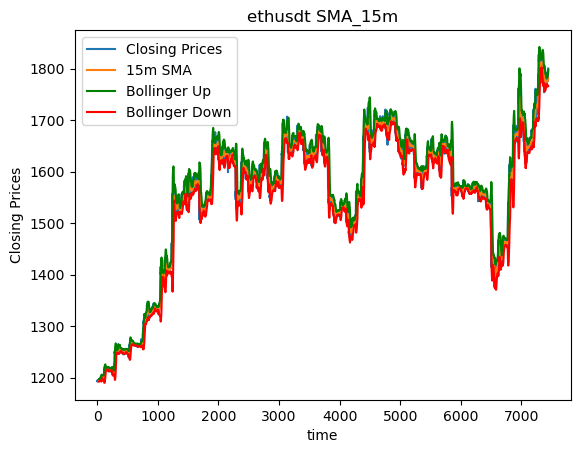

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()